In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
import os, cv2
import tensorflow as tf
from PIL import Image
import uuid
import shutil
from PIL import ImageOps
import random
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [3]:
# !pip install opencv-contrib-python
df= pd.read_csv('E:/Corneal_Ulcer/dataset/labels.csv')
img_dir=  "E:/Corneal_Ulcer/dataset/images/"
# type_dir= "E:/Corneal_Ulcer/type/"
type_dir= os.getcwd() + "/type/"

grade_dir= os.getcwd()+ "/grade/"

train_dir= os.getcwd() + "/train/"

test_dir= os.getcwd() + "/test/"

df.head()

,name,category,type,grade
0,1.jpg,0,4,3
1,2.jpg,0,4,3
2,3.jpg,0,2,2
3,4.jpg,0,2,1
4,5.jpg,0,1,3


In [4]:
df.shape


(712, 4)

In [5]:
df.isnull().sum()

name        0
category    0
type        0
grade       0
dtype: int64

In [6]:

labeling = df['grade'].value_counts().sort_index()
labeling= labeling.astype(int)
print(labeling)

grade
0     36
1     98
2    203
3    273
4    102
Name: count, dtype: int32


In [11]:
def print_random_image_id(dataframe):
    unique_dx = dataframe['grade'].unique()
    dict = {}
    for dx_value in unique_dx:
        subset = dataframe[dataframe['grade'] == dx_value]
        random_row = random.choice(subset.index)
        image_id = subset.loc[random_row, 'name']
        dict[dx_value]= image_id
    
    return dict

In [12]:
paths  = print_random_image_id(df)
print(paths)

{3: '136.jpg', 2: '201.jpg', 1: '505.jpg', 0: '16.jpg', 4: '653.jpg'}


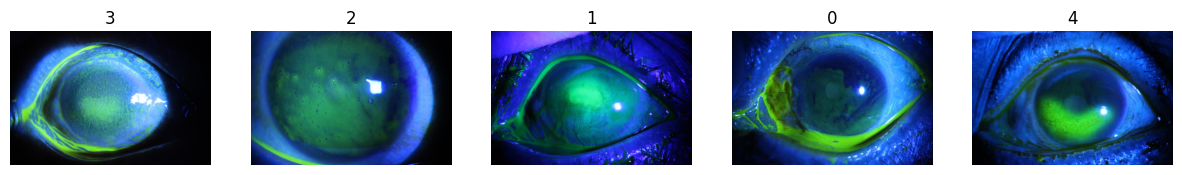

In [15]:
image_paths= paths

fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))

for i, (label, name) in enumerate(image_paths.items()):
    img_path = f'../dataset/images/{name}'
    image = Image.open(img_path)
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

In [7]:
# class_names = ['No Ulcer', 'Micro punctate','Macro punctate', 'Coalescent macro punctate', 'Patch']
class_names = ['grade 0', 'grade 1','grade 2', 'grade 3', 'grade 4']


class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
print(class_names_label)
nb_classes = len(class_names)
label_images= []
j= 0
for i in class_names_label:
  os.makedirs(type_dir + str(i) + '/' , exist_ok= True)
  os.makedirs(grade_dir + str(i) + '/' , exist_ok= True)
  os.makedirs(train_dir + str(i) + '/' , exist_ok= True)
  os.makedirs(test_dir + str(i) + '/' , exist_ok= True)


for i in class_names_label:

  sample = df[df['grade'] == j]['name']
  label_images.extend(sample)
  x=0
  for id in label_images:
    path= img_dir + "/" +id
    existence= os.path.isfile(path)

    if(existence is True):

            shutil.copyfile((img_dir + "/"+ id), (grade_dir + str(i) + "/"+ id))
            
            if  x<=round(0.25 * len(sample)): #20 percent of images
                shutil.copyfile((img_dir + "/"+ id), (test_dir + str(i) + "/"+ id))
            else:
                shutil.copyfile((img_dir + "/"+ id), (train_dir + str(i) + "/"+ id)) 
            x+=1
            # print("success")

  j+=1
  label_images=[]

{'grade 0': 0, 'grade 1': 1, 'grade 2': 2, 'grade 3': 3, 'grade 4': 4}


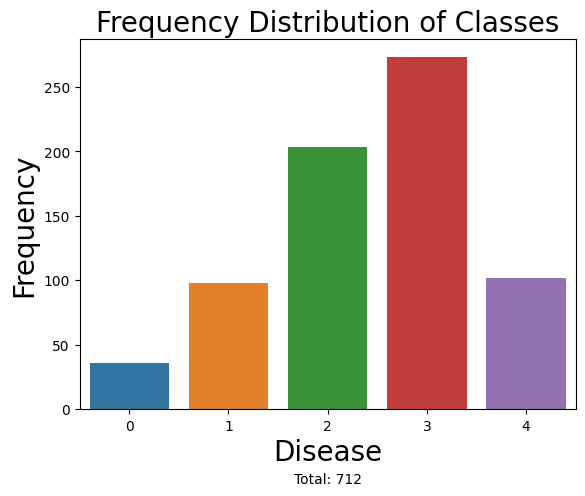

In [16]:
value_counts = df['grade'].value_counts()

# Frequency Distribution of Data
ax = sns.countplot(x='grade', data=df)
plt.xlabel('Disease', size=20)
plt.ylabel('Frequency', size=20)
plt.title('Frequency Distribution of Classes', size=20)

# Add total value as text below the x-axis label
total_value = value_counts.sum()
plt.text(0.5, -0.2, f'Total: {total_value}', ha='center', transform=ax.transAxes, fontsize=10)


plt.show()

Text(0.5, 1.0, 'Grade')

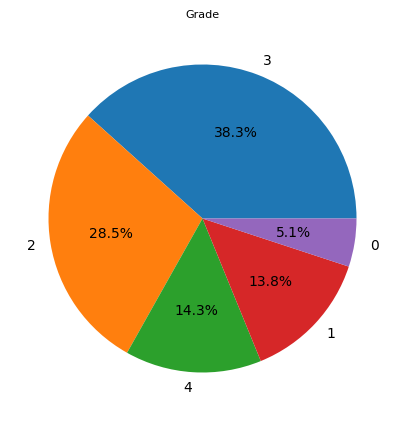

In [17]:
bar, ax = plt.subplots(figsize = (5,5))
plt.pie(df['grade'].value_counts(), 
        labels = df['grade'].value_counts().index, 
        autopct="%.1f%%")
plt.title('Grade', size=8)

In [18]:
# Get the grade_subdirectory
print('Images from the dataset without balance \n')
grade_subdir = os.listdir(grade_dir)

# Initialize a dictionary to store the counts
img_counts = {}

# Iterate over each subdirectory
for grades in grade_subdir:
    # Get the full path to the subdirectory
    grade_subdir_path = os.path.join(grade_dir, grades)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(grade_subdir_path):
        # Count the number of files in the subdirectory
        num_files = len(os.listdir(grade_subdir_path))
        
        # Store the count in the dictionary
        img_counts[grades] = num_files

# Print the counts
for label, count in img_counts.items():
    print(f'{label}: {count} images')

Images from the dataset without balance 

grade 0: 36 images
grade 1: 98 images
grade 2: 203 images
grade 3: 273 images
grade 4: 102 images


In [9]:
def image_augmentation(image):
    # List of augmentations
    augmentations = ['flip_left_right', 'flip_top_bottom', 'rotate', 'mirror']

    # Randomly select an augmentation
    augmentation = random.choice(augmentations)

    # Apply the augmentation
    if augmentation == 'flip_left_right':
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    elif augmentation == 'flip_top_bottom':
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    elif augmentation == 'rotate':
        image = image.rotate(random.randint(0, 360))  # rotate by a random angle
    elif augmentation == 'mirror':
        image = ImageOps.mirror(image)

    return image

In [21]:
# Define the source directory and target directory
source_dir = grade_dir  # replace with your source directory path
target_dir = '../2.0/aug_grade'  # replace with your target directory path

# Use try-except block to handle any errors
try:
    # Copy the entire directory tree
    shutil.copytree(source_dir, target_dir)
    print("Files copied successfully.")
except FileExistsError:
    print("Target directory already exists. Please choose a non-existing directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Target directory already exists. Please choose a non-existing directory.


In [11]:
parent_dir= target_dir
# Get the subdirectories
subdirectories = os.listdir(parent_dir)

# Iterate over each subdirectory
for subdir in subdirectories:
    # Get the full path to the subdirectory
    subdir_path = os.path.join(parent_dir, subdir)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(subdir_path):
        # Get the list of files in the subdirectory
        files = os.listdir(subdir_path)
        
        # If there are less than 6705 files
        if len(files) < 300 :
            # Continue augmenting until there are 1000 images
            while len(files) < 300:
                # Randomly select a file
                file = random.choice(files)
                
                # Load the image file
                img = Image.open(os.path.join(subdir_path, file))
                
                # Augment the image
                img_augmented = image_augmentation(img)  # replace with your function
                # Generate a unique filename using UUID
                filename = str(uuid.uuid4()) + '.jpg'
                # Save the augmented image
                img_augmented.save(os.path.join(subdir_path, filename))
                
                # Update the list of files
                files = os.listdir(subdir_path)

In [23]:
# Get the grade_subdirectory
print('Images from the dataset after balancing \n')
target_subdir = os.listdir(target_dir)

# Initialize a dictionary to store the counts
img_counts = {}

# Iterate over each subdirectory
for grades in target_subdir:
    # Get the full path to the subdirectory
    target_subdir_path = os.path.join(target_dir, grades)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(target_subdir_path):
        # Count the number of files in the subdirectory
        num_files = len(os.listdir(target_subdir_path))
        
        # Store the count in the dictionary
        img_counts[grades] = num_files

# Print the counts
for label, count in img_counts.items():
    print(f'{label}: {count} images')

Images from the dataset after balancing 

grade 0: 300 images
grade 1: 300 images
grade 2: 300 images
grade 3: 300 images
grade 4: 300 images


In [12]:
sdir=r'E:\Corneal_Ulcer\2.0'
aug_dir=os.path.join(sdir,'augmented_grade')
if os.path.isdir(aug_dir): # see if aug_dir exists if so remove it to get a clean slate
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir) # make a new empty aug_dir
filepaths=[]
labels=[]
# iterate through original_images and create a dataframe of the form filepaths, labels
original_images_dir=os.path.join(sdir, 'aug_grade')
# for klass in ['No Ulcer', 'Micro punctate','Macro punctate', 'Coalescent macro punctate', 'Patch']:
for klass in ['grade 0', 'grade 1','grade 2', 'grade 3', 'grade 4']:

    os.mkdir(os.path.join(aug_dir,klass)) # make the class subdirectories in the aug_dir
    classpath=os.path.join(original_images_dir, klass) # get the path to the classes (benign and maligant)
    flist=os.listdir(classpath)# for each class the the list of files in the class    
    for f in flist:        
        fpath=os.path.join(classpath, f) # get the path to the file
        filepaths.append(fpath)
        labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1) # create the dataframe
gen=ImageDataGenerator(
    rescale=1.0/255,        # Normalize pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in/out on images
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=False     # Not recommended for eye images (can lead to unrealistic data)
)
groups=df.groupby('labels') # group by class
i=0
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    aug_img_count=0
    sample_count=2400
    target_dir=os.path.join(aug_dir, label)  # define where to write the images    
    aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=True, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
    while aug_img_count<sample_count:
        images=next(aug_gen)            
        aug_img_count += 1 
    
    

Found 300 validated image filenames.
Found 300 validated image filenames.
Found 300 validated image filenames.
Found 300 validated image filenames.
Found 300 validated image filenames.


In [27]:
sdir=r'E:\Corneal_Ulcer\2.0'
aug_dir=os.path.join(sdir,'augmented_grade')
# Get the grade_subdirectory
print('Images from the dataset after augmentation \n')
aug_subdir = os.listdir(aug_dir)

# Initialize a dictionary to store the counts
img_counts = {}

# Iterate over each subdirectory
for grades in aug_subdir:
    # Get the full path to the subdirectory
    aug_subdir_path = os.path.join(aug_dir, grades)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(aug_subdir_path):
        # Count the number of files in the subdirectory
        num_files = len(os.listdir(aug_subdir_path))
        
        # Store the count in the dictionary
        img_counts[grades] = num_files

# Print the counts
for label, count in img_counts.items():
    print(f'{label}: {count} images')

Images from the dataset after augmentation 

grade 0: 2400 images
grade 1: 2400 images
grade 2: 2400 images
grade 3: 2400 images
grade 4: 2400 images
